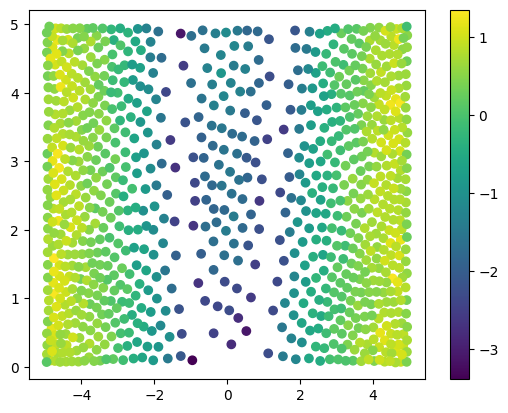

In [1]:
from FlowStorm.flow_surface import FlowSurface
from FlowStorm.toy_data import generate_discrete_dataset, generate_snowstorm_dataset
from FlowStorm.clusters import make_snowstorm_anchors_density, make_uniform_grid_anchors_density, make_adaptive_anchors_density
from FlowStorm.yield_model import YieldModel_RBF, YieldModel_Poly, YieldModel_Spline, YieldModel_SmoothingSpline
import jax.random as jr
import jax.numpy as jnp
import numpy as onp

import matplotlib.pyplot as plt
rng = jr.key(187)
N = 10_000_000
base_mu = 0.
base_sigma = 3.
baseline_data = generate_discrete_dataset(rng,base_mu,base_sigma,N)
base_alphas = jnp.array([base_mu]*N)
rng, subkey = jr.split(rng)
snowstorm_data, alphas = generate_snowstorm_dataset(subkey,N)
len(snowstorm_data), len(alphas)
# anchors, yields = make_snowstorm_anchors_density(alphas,n_anchors=51)
#anchors, yields = make_uniform_grid_anchors_density(alphas,n_anchors=30**2)
# anchors, yields = make_snowstorm_anchors_density(alphas,n_anchors=30**2)
anchors, yields= make_adaptive_anchors_density(alphas,n_anchors=900,weight_mix=0.3)
plt.scatter(anchors[:,0],anchors[:,1],c=yields)
plt.colorbar()
yld = YieldModel_RBF(anchors,yields)

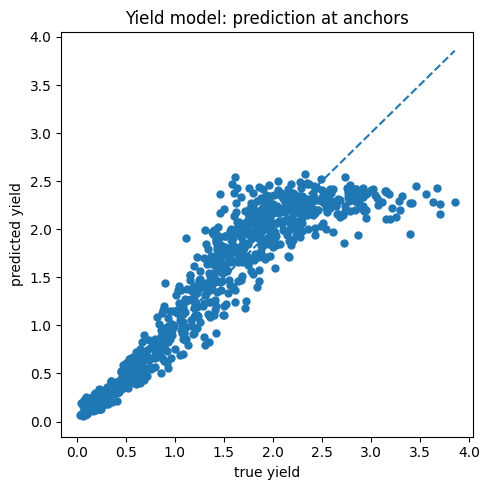

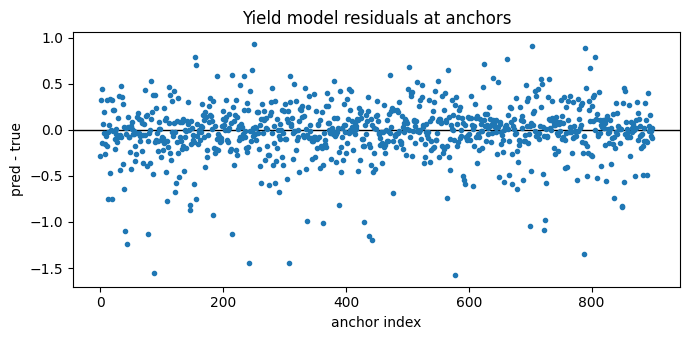

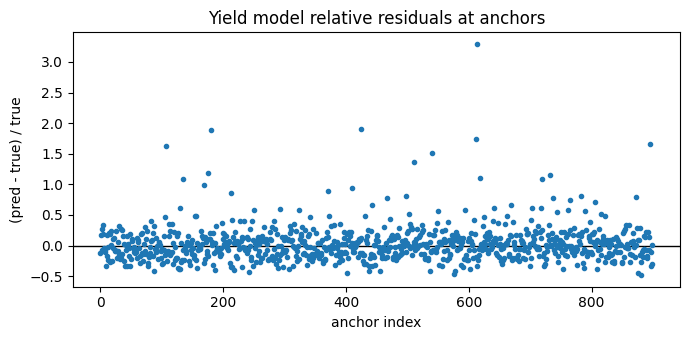

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# anchors: (K,D)
# true yields: either counts/efficiencies OR logq targets, depending on your setup
A = np.asarray(anchors)
y_true = np.exp(np.asarray(yields).reshape(-1))

# --- model prediction at anchor points ---
# If your YieldModel returns N ~ exp(logq), this is fine.
# If your "true" targets are logq, compare in log-space instead (see below).
y_pred = np.asarray([yld.N(a) for a in A])

# ---------- Plot 1: predicted vs true ----------
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(y_true, y_pred, s=25)
mn = min(y_true.min(), y_pred.min())
mx = max(y_true.max(), y_pred.max())
ax.plot([mn, mx], [mn, mx], "--")
ax.set_xlabel("true yield")
ax.set_ylabel("predicted yield")
ax.set_title("Yield model: prediction at anchors")
plt.tight_layout()
plt.show()

# ---------- Plot 2: residuals (pred - true) ----------
res = y_pred - y_true

fig, ax = plt.subplots(figsize=(7, 3.5))
ax.axhline(0.0, color="k", lw=1)
ax.plot(np.arange(len(res)), res, "o", ms=3)
ax.set_xlabel("anchor index")
ax.set_ylabel("pred - true")
ax.set_title("Yield model residuals at anchors")
plt.tight_layout()
plt.show()

# ---------- Plot 3: relative residuals ----------
eps = 1e-12
rel = (y_pred - y_true) / (y_true + eps)

fig, ax = plt.subplots(figsize=(7, 3.5))
ax.axhline(0.0, color="k", lw=1)
ax.plot(np.arange(len(rel)), rel, "o", ms=3)
ax.set_xlabel("anchor index")
ax.set_ylabel("(pred - true) / true")
ax.set_title("Yield model relative residuals at anchors")
plt.tight_layout()
plt.show()

# ---------- If your yields are actually log-targets (logq), use this instead ----------
# Uncomment if applicable:
# log_true = y_true
# log_pred = np.asarray([yld.logN(a) for a in A])
# dlog = log_pred - log_true
# fig, ax = plt.subplots(figsize=(7, 3.5))
# ax.axhline(0.0, color="k", lw=1)
# ax.plot(np.arange(len(dlog)), dlog, "o", ms=3)
# ax.set_xlabel("anchor index")
# ax.set_ylabel("log_pred - log_true")
# ax.set_title("Yield model residuals in log-space at anchors")
# plt.tight_layout()
# plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt

A = np.asarray(anchors)          # (K, D)
y_true = np.exp(np.asarray(yields))      # true targets at anchors
y_pred = np.array([yld.N(a) for a in A])

=== Overfit check (log-space) ===
TRAIN: RMSE=0.2414  MAE=0.1781  median=-0.00562  |res|95%=0.4745  Corr=0.969
VAL  : RMSE=0.8058  MAE=0.7461  median=-0.711  |res|95%=1.245  Corr=0.9247
VAL/TRAIN RMSE ratio: 3.338  (>>1 suggests overfit or distribution shift)


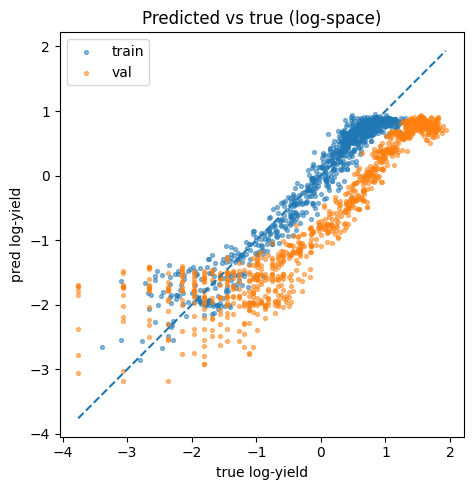

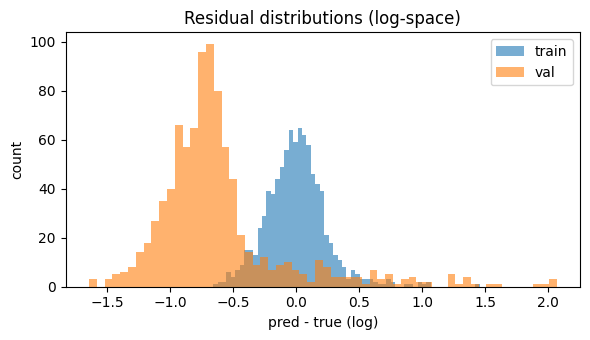

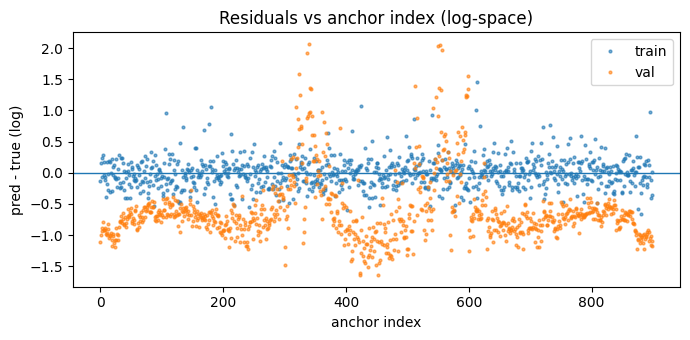

In [4]:
import jax.random as jr
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Assumptions:
# - anchors, yields  : your TRAIN anchors and TRAIN log-yields (yields are already log)
# - yld             : your trained YieldModel_SmoothingSpline
# If yld is not trained yet, uncomment the fit line below.
# -------------------------

A_train = np.asarray(anchors, float)
logy_train = np.asarray(yields, float).reshape(-1)

# (Optional) fit here if needed:
# yld = YieldModel_SmoothingSpline(A_train, logy_train, lam=1e-2)

# --------- Build independent validation set (new SnowStorm sample + new anchors) ---------
rng = jr.key(1234)
N_val = 1_000_000
rng, subkey = jr.split(rng)
snowstorm_val, alphas_val = generate_snowstorm_dataset(subkey, N_val)

anchors_val, logy_val = make_uniform_grid_anchors_density(alphas_val, n_anchors=30**2)
A_val = np.asarray(anchors_val, float)
logy_val = np.asarray(logy_val, float).reshape(-1)

# --------- Predict train + val ---------
pred_train = np.asarray(yld.logN(A_train), float).reshape(-1)
pred_val   = np.asarray(yld.logN(A_val),   float).reshape(-1)

res_train = pred_train - logy_train
res_val   = pred_val   - logy_val

def metrics(res):
    rmse = float(np.sqrt(np.mean(res**2)))
    mae  = float(np.mean(np.abs(res)))
    med  = float(np.median(res))
    p95  = float(np.percentile(np.abs(res), 95))
    return rmse, mae, med, p95

rmse_tr, mae_tr, med_tr, p95_tr = metrics(res_train)
rmse_va, mae_va, med_va, p95_va = metrics(res_val)

corr_tr = float(np.corrcoef(logy_train, pred_train)[0, 1])
corr_va = float(np.corrcoef(logy_val,   pred_val)[0, 1])

print("=== Overfit check (log-space) ===")
print(f"TRAIN: RMSE={rmse_tr:.4g}  MAE={mae_tr:.4g}  median={med_tr:.3g}  |res|95%={p95_tr:.4g}  Corr={corr_tr:.4g}")
print(f"VAL  : RMSE={rmse_va:.4g}  MAE={mae_va:.4g}  median={med_va:.3g}  |res|95%={p95_va:.4g}  Corr={corr_va:.4g}")

# Heuristic flag
ratio = rmse_va / (rmse_tr + 1e-12)
print(f"VAL/TRAIN RMSE ratio: {ratio:.3f}  (>>1 suggests overfit or distribution shift)")

# --------- Plots ---------
# (1) Pred vs True: Train & Val
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(logy_train, pred_train, s=8, alpha=0.5, label="train")
ax.scatter(logy_val,   pred_val,   s=8, alpha=0.5, label="val")

mn = min(logy_train.min(), logy_val.min(), pred_train.min(), pred_val.min())
mx = max(logy_train.max(), logy_val.max(), pred_train.max(), pred_val.max())
ax.plot([mn, mx], [mn, mx], "--")
ax.set_xlabel("true log-yield")
ax.set_ylabel("pred log-yield")
ax.set_title("Predicted vs true (log-space)")
ax.set_aspect("equal", adjustable="box")
ax.legend()
plt.tight_layout()
plt.show()

# (2) Residual histograms: Train vs Val
fig, ax = plt.subplots(figsize=(6, 3.5))
ax.hist(res_train, bins=60, alpha=0.6, label="train")
ax.hist(res_val,   bins=60, alpha=0.6, label="val")
ax.set_xlabel("pred - true (log)")
ax.set_ylabel("count")
ax.set_title("Residual distributions (log-space)")
ax.legend()
plt.tight_layout()
plt.show()

# (3) Residuals vs index: Train & Val
fig, ax = plt.subplots(figsize=(7, 3.5))
ax.axhline(0.0, lw=1)
ax.plot(np.arange(len(res_train)), res_train, "o", ms=2, alpha=0.6, label="train")
ax.plot(np.arange(len(res_val)),   res_val,   "o", ms=2, alpha=0.6, label="val")
ax.set_xlabel("anchor index")
ax.set_ylabel("pred - true (log)")
ax.set_title("Residuals vs anchor index (log-space)")
ax.legend()
plt.tight_layout()
plt.show()

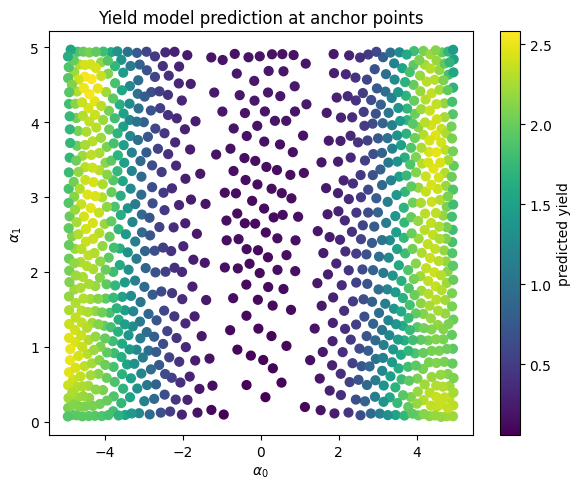

In [5]:
fig, ax = plt.subplots(figsize=(6, 5))

sc = ax.scatter(
    A[:, 0], A[:, 1],
    c=y_pred,
    s=40,
    cmap="viridis",
)

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("predicted yield")

ax.set_xlabel(r"$\alpha_0$")
ax.set_ylabel(r"$\alpha_1$")
ax.set_title("Yield model prediction at anchor points")

plt.tight_layout()
plt.show()

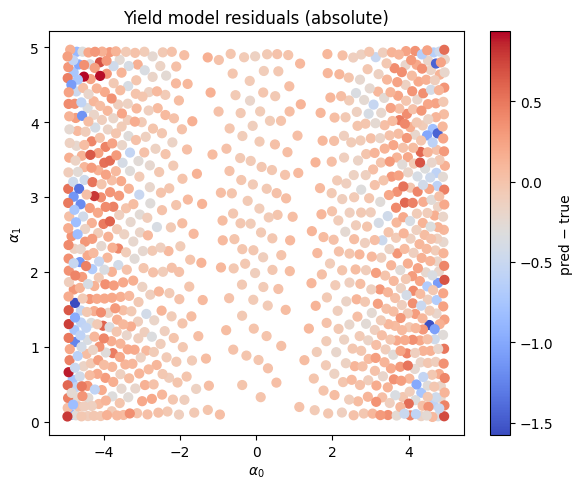

In [6]:
diff = y_pred - y_true

fig, ax = plt.subplots(figsize=(6, 5))

sc = ax.scatter(
    A[:, 0], A[:, 1],
    c=diff,
    s=40,
    cmap="coolwarm",
)

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("pred − true")

ax.set_xlabel(r"$\alpha_0$")
ax.set_ylabel(r"$\alpha_1$")
ax.set_title("Yield model residuals (absolute)")

plt.tight_layout()
plt.show()

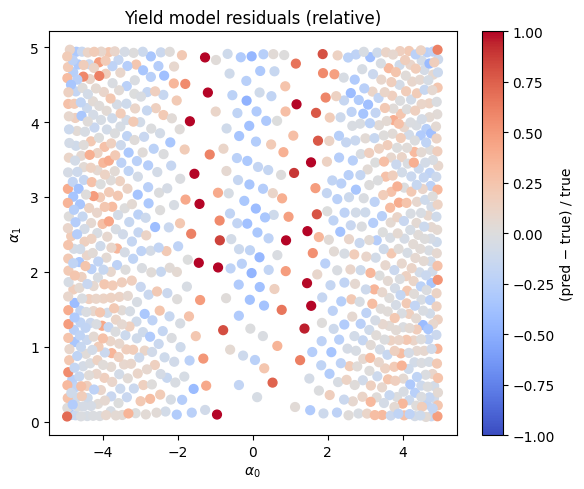

In [7]:
eps = 1e-12
rel = diff / (y_true)

fig, ax = plt.subplots(figsize=(6, 5))

sc = ax.scatter(
    A[:, 0], A[:, 1],
    c=rel,
    s=40,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
)

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("(pred − true) / true")

ax.set_xlabel(r"$\alpha_0$")
ax.set_ylabel(r"$\alpha_1$")
ax.set_title("Yield model residuals (relative)")

plt.tight_layout()
plt.show()